In [1]:
#!git clone https://github.com/spMohanty/PlantVillage-Dataset
#!cd PlantVillage-Dataset

In [2]:
import numpy as np
import pickle
import cv2
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from os import listdir, mkdir
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
#from keras.utils import img_to_array
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

In [3]:
data_dir = "/kaggle/input/plantvillage-dataset/color"

classes = listdir(data_dir)
classes

['Tomato___Late_blight',
 'Tomato___healthy',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Potato___healthy',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Tomato___Early_blight',
 'Tomato___Septoria_leaf_spot',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Strawberry___Leaf_scorch',
 'Peach___healthy',
 'Apple___Apple_scab',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Bacterial_spot',
 'Apple___Black_rot',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Peach___Bacterial_spot',
 'Apple___Cedar_apple_rust',
 'Tomato___Target_Spot',
 'Pepper,_bell___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Potato___Late_blight',
 'Tomato___Tomato_mosaic_virus',
 'Strawberry___healthy',
 'Apple___healthy',
 'Grape___Black_rot',
 'Potato___Early_blight',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Common_rust_',
 'Grape___Esca_(Black_Measles)',
 'Raspberry___healthy'

In [4]:
#mkdir(data_dir + 'test_data')
#mkdir(data_dir + 'train_data')

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # Resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
num_classes = 38


In [6]:
def convert_image_to_array(image_dir):
  image = cv2.imread(image_dir)
  if image is not None :  
    return img_to_array(image)
  else :
    return np.array([])

In [7]:
image_list, label_list = [], []

print("Loading images ...")
root_dir = listdir(data_dir)

for plant_folder in root_dir :
    plant_disease_image_list = listdir(f"{data_dir}/{plant_folder}")
    print(len(plant_disease_image_list))
    for image in plant_disease_image_list[:100]:
        image_directory = f"{data_dir}/{plant_folder}/{image}"
        if image_directory.lower().endswith(".jpg"):
            image_list.append(convert_image_to_array(image_directory))
            label_list.append(plant_folder)
print("Image loading completed")  

Loading images ...
1909
1591
423
5507
5090
1835
152
985
1000
1771
513
1109
360
630
5357
2127
621
1502
1052
2297
275
1404
1478
1076
1000
373
456
1645
1180
1000
854
1192
1383
371
952
1676
997
1162
Image loading completed


In [8]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [9]:
print(label_binarizer.classes_)

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tom

In [10]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [11]:
print("Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

Spliting data to train, test


In [26]:
input_shape = x_train[0].shape
print(input_shape)

(256, 256, 3)


In [13]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

2023-02-01 19:16:02.215465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 19:16:02.216581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 19:16:02.339556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 19:16:02.340388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 19:16:02.341204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [14]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [15]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


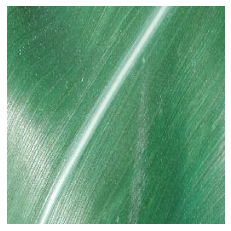

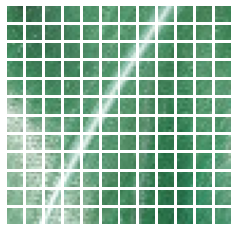

In [16]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
image = image * 225.0
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


In [17]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [18]:
def create_vit_classifier(with_attention_scores_output=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    attention_score_dict = dict()

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output, attention_score = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1, return_attention_scores=True)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
        
        attention_score_dict[i] = attention_score

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    if with_attention_scores_output:
        model = keras.Model(inputs=inputs, outputs=[logits, attention_score_dict])
    else:
        model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [19]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


2023-02-01 19:16:22.696720: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2151677952 exceeds 10% of free system memory.
2023-02-01 19:16:25.088615: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2151677952 exceeds 10% of free system memory.


Epoch 1/100
11/11 [==============================] - 19s 634ms/step - loss: 4.5576 - accuracy: 0.1012 - top-5-accuracy: 0.2982 - val_loss: 2.7751 - val_accuracy: 0.2599 - val_top-5-accuracy: 0.5691
Epoch 2/100
11/11 [==============================] - 5s 468ms/step - loss: 3.0885 - accuracy: 0.1970 - top-5-accuracy: 0.4952 - val_loss: 2.4063 - val_accuracy: 0.3191 - val_top-5-accuracy: 0.6743
Epoch 3/100
11/11 [==============================] - 5s 451ms/step - loss: 2.7145 - accuracy: 0.2657 - top-5-accuracy: 0.6023 - val_loss: 2.1349 - val_accuracy: 0.3947 - val_top-5-accuracy: 0.7533
Epoch 4/100
11/11 [==============================] - 5s 478ms/step - loss: 2.4462 - accuracy: 0.3249 - top-5-accuracy: 0.6703 - val_loss: 2.0473 - val_accuracy: 0.4243 - val_top-5-accuracy: 0.7829
Epoch 5/100
11/11 [==============================] - 5s 468ms/step - loss: 2.2455 - accuracy: 0.3644 - top-5-accuracy: 0.7251 - val_loss: 1.8077 - val_accuracy: 0.4934 - val_top-5-accuracy: 0.8388
Epoch 6/100
11

2023-02-01 19:25:51.290614: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 597688320 exceeds 10% of free system memory.


24/24 [==============================] - 1s 36ms/step - loss: 0.6115 - accuracy: 0.8579 - top-5-accuracy: 0.9750
Test accuracy: 85.79%
Test top 5 accuracy: 97.5%


dict_keys(['loss', 'accuracy', 'top-5-accuracy', 'val_loss', 'val_accuracy', 'val_top-5-accuracy'])


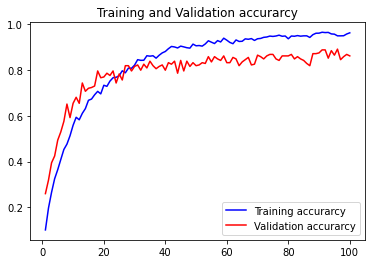

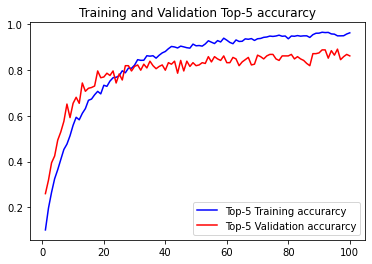

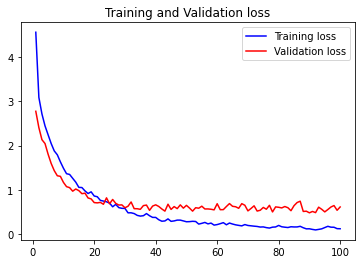

In [20]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
top_5_acc = history.history['top-5-accuracy']
op_5_val_acc = history.history['val_top-5-accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b', label='Top-5 Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Top-5 Validation accurarcy')
plt.title('Training and Validation Top-5 accurarcy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

print(model.predict(x_test[0]))

In [21]:
vit_classifier_with_att_scores = create_vit_classifier(with_attention_scores_output=True)
checkpoint_filepath = "/tmp/checkpoint"
vit_classifier_with_att_scores.load_weights(checkpoint_filepath)

(-0.5, 255.5, 255.5, -0.5)

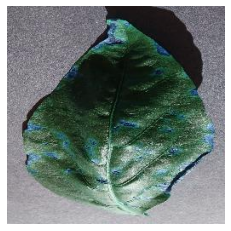

In [126]:
plt.figure(figsize=(4, 4))
image_to_predict = x_train[np.random.choice(range(x_train.shape[0]))]
image_to_draw = image_to_predict * 225.0
plt.imshow(image_to_draw.astype("uint8"))
plt.axis("off")

In [127]:
image_to_predict = np.expand_dims(image_to_predict, axis=0)

In [128]:
output, attention_scores  = vit_classifier_with_att_scores(image_to_predict)

In [159]:
# computes attention rollout map
def attention_map(src_image, attention_score_dict):
    attention_mat = tf.stack(list(attention_score_dict.values()))
    print(attention_mat.shape)
    attention_mat = tf.squeeze(attention_mat, axis=1)
    print(attention_mat.shape)

    # Average attention (for all heads) per MultiHeadAttention layers
    attention_mat = tf.reduce_mean(attention_mat, axis=1)
    print(attention_mat.shape)

    # "to account for residual connections, we add an identity matrix to the attention matrix and re-normalize the weights"
    residual_attn = tf.eye(attention_mat.shape[1])
    print(residual_attn.shape)
    aug_attention_mat = attention_mat + residual_attn
    aug_attention_mat = np.array(aug_attention_mat / tf.reduce_sum(aug_attention_mat, axis=-1)[..., None])
    print(aug_attention_mat.shape)

    # Recursive formula on Vl+1
    joint_attentions = np.zeros(aug_attention_mat.shape)
    joint_attentions[0] = aug_attention_mat[0]
    for n in range(1, aug_attention_mat.shape[0]):
        joint_attentions[n] = np.matmul(aug_attention_mat[n], joint_attentions[n - 1])

    # Reshape last calculated attention that we can multiply it by the input RGB image
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_attention_mat.shape[-1]))
    mask = v[0].reshape(grid_size, grid_size)
    #print(src_image.shape[:2])
    #print(src_image.size)
    mask = cv2.resize(mask / mask.max(), src_image.shape[:2])[..., np.newaxis] #[: ,:, np.newaxis]
    #print(mask.shape)
    result = (mask * src_image).astype("uint8")
    return result


(8, 1, 4, 144, 144)
(8, 4, 144, 144)
(8, 144, 144)
(144, 144)
(8, 144, 144)


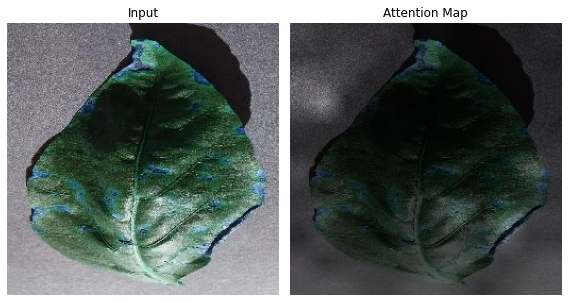

In [160]:
attn_rollout_result = attention_map(image_to_draw, attention_scores)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 10))

ax1.imshow(image_to_draw.astype("uint8"))
ax2.imshow(attn_rollout_result)
ax1.axis("off")
ax2.axis("off")
ax1.set_title("Input")
ax2.set_title("Attention Map")
fig.tight_layout()
fig.show()
